In [2]:
"""
Simplified standalone version of Hyena: https://arxiv.org/abs/2302.10866, designed for quick experimentation.
A complete version is available under `src.models.sequence.hyena`.
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange


def fftconv(u, k, D):
    seqlen = u.shape[-1]
    fft_size = 2 * seqlen
    
    k_f = torch.fft.rfft(k, n=fft_size) / fft_size
    u_f = torch.fft.rfft(u.to(dtype=k.dtype), n=fft_size)
    
    if len(u.shape) > 3: k_f = k_f.unsqueeze(1)
    y = torch.fft.irfft(u_f * k_f, n=fft_size, norm='forward')[..., :seqlen]

    out = y + u * D.unsqueeze(-1)
    return out.to(dtype=u.dtype)


@torch.jit.script 
def mul_sum(q, y):
    return (q * y).sum(dim=1)

class OptimModule(nn.Module):
    """ Interface for Module that allows registering buffers/parameters with configurable optimizer hyperparameters """

    def register(self, name, tensor, lr=None, wd=0.0):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {}
            if lr is not None: optim["lr"] = lr
            if wd is not None: optim["weight_decay"] = wd
            setattr(getattr(self, name), "_optim", optim)
            

class Sin(nn.Module):
    def __init__(self, dim, w=10, train_freq=True):
        super().__init__()
        self.freq = nn.Parameter(w * torch.ones(1, dim)) if train_freq else w * torch.ones(1, dim)

    def forward(self, x):
        return torch.sin(self.freq * x)
    
    
class PositionalEmbedding(OptimModule):
    def __init__(self, emb_dim: int, seq_len: int, lr_pos_emb: float=1e-5, **kwargs): 
        """Complex exponential positional embeddings for Hyena filters."""  
        super().__init__()
        
        self.seq_len = seq_len
        # The time embedding fed to the filteres is normalized so that t_f = 1
        t = torch.linspace(0, 1, self.seq_len)[None, :, None] # 1, L, 1
        
        if emb_dim > 1:
            bands = (emb_dim - 1) // 2            
        # To compute the right embeddings we use the "proper" linspace 
        t_rescaled = torch.linspace(0, seq_len - 1, seq_len)[None, :, None]
        w = 2 * math.pi * t_rescaled / seq_len # 1, L, 1 
        
        f = torch.linspace(1e-4, bands - 1, bands)[None, None] 
        z = torch.exp(-1j * f * w)
        z = torch.cat([t, z.real, z.imag], dim=-1)
        self.register("z", z, lr=lr_pos_emb) 
        self.register("t", t, lr=0.0)
        
    def forward(self, L):
        return self.z[:, :L], self.t[:, :L]
    

class ExponentialModulation(OptimModule):
    def __init__(
        self,
        d_model,
        fast_decay_pct=0.3,
        slow_decay_pct=1.5,
        target=1e-2,
        modulation_lr=0.0,
        modulate: bool=True,
        shift: float = 0.0,
        **kwargs
    ):
        super().__init__()
        self.modulate = modulate
        self.shift = shift
        max_decay = math.log(target) / fast_decay_pct
        min_decay = math.log(target) / slow_decay_pct
        deltas = torch.linspace(min_decay, max_decay, d_model)[None, None]
        self.register("deltas", deltas, lr=modulation_lr)
        
    def forward(self, t, x):
        if self.modulate:
            decay = torch.exp(-t * self.deltas.abs()) 
            x = x * (decay + self.shift)
        return x                  


class HyenaFilter(OptimModule):
    def __init__(
            self, 
            d_model,
            emb_dim=3, # dim of input to MLP, augments with positional encoding
            order=16, # width of the implicit MLP 
            fused_fft_conv=False,
            seq_len=1024, 
            lr=1e-3, 
            lr_pos_emb=1e-5,
            dropout=0.0, 
            w=1, # frequency of periodic activations 
            wd=0, # weight decay of kernel parameters 
            bias=True,
            num_inner_mlps=2,
            normalized=False,
            **kwargs
        ):
        """
        Implicit long filter with modulation.
        
        Args:
            d_model: number of channels in the input
            emb_dim: dimension of the positional encoding (`emb_dim` - 1) // 2 is the number of bands
            order: width of the FFN
            num_inner_mlps: number of inner linear layers inside filter MLP
        """
        super().__init__()
        self.d_model = d_model
        self.use_bias = bias
        self.fused_fft_conv = fused_fft_conv
        self.bias = nn.Parameter(torch.randn(self.d_model))
        self.dropout = nn.Dropout(dropout)
        
        act = Sin(dim=order, w=w)
        self.emb_dim = emb_dim
        assert emb_dim % 2 != 0 and emb_dim >= 3, "emb_dim must be odd and greater or equal to 3 (time, sine and cosine)"
        self.seq_len = seq_len
  
        self.pos_emb = PositionalEmbedding(emb_dim, seq_len, lr_pos_emb)
        
        self.implicit_filter = nn.Sequential(
            nn.Linear(emb_dim, order),
            act,
        )
        for i in range(num_inner_mlps):
            self.implicit_filter.append(nn.Linear(order, order))
            self.implicit_filter.append(act)

        self.implicit_filter.append(nn.Linear(order, d_model, bias=False))
            
        self.modulation = ExponentialModulation(d_model, **kwargs)
        
        self.normalized = normalized
        for c in self.implicit_filter.children():
            for name, v in c.state_dict().items():        
                optim = {"weight_decay": wd, "lr": lr}
                setattr(getattr(c, name), "_optim", optim)

    def filter(self, L, *args, **kwargs):
        z, t = self.pos_emb(L)
        h = self.implicit_filter(z)
        h = self.modulation(t, h)
        return h

    def forward(self, x, L, k=None, bias=None, *args, **kwargs):
        if k is None: k = self.filter(L)
        
        # Ensure compatibility with filters that return a tuple 
        k = k[0] if type(k) is tuple else k 

        y = fftconv(x, k, bias)
        return y
    
    
class HyenaOperator(nn.Module):
    def __init__(
            self,
            d_model,
            l_max,
            order=2, 
            filter_order=64,
            dropout=0.0,  
            filter_dropout=0.0, 
            **filter_args,
        ):
        r"""
        Hyena operator described in the paper https://arxiv.org/pdf/2302.10866.pdf
        
        Args:
            d_model (int): Dimension of the input and output embeddings (width of the layer)
            l_max: (int): Maximum input sequence length. Defaults to None
            order: (int): Depth of the Hyena recurrence. Defaults to 2
            dropout: (float): Dropout probability. Defaults to 0.0
            filter_dropout: (float): Dropout probability for the filter. Defaults to 0.0
        """
        super().__init__()
        self.d_model = d_model
        self.l_max = l_max
        self.order = order
        inner_width = d_model * (order + 1)
        self.dropout = nn.Dropout(dropout)
        self.in_proj = nn.Linear(d_model, inner_width)
        self.out_proj = nn.Linear(d_model, d_model)
        
        self.short_filter = nn.Conv1d(
            inner_width, 
            inner_width, 
            3,
            padding=2,
            groups=inner_width
        )
        self.filter_fn = HyenaFilter(
            d_model * (order - 1), 
            order=filter_order, 
            seq_len=l_max,
            channels=1, 
            dropout=filter_dropout, 
            **filter_args
        ) 

    def forward(self, u, *args, **kwargs):
        l = u.size(-2)
        l_filter = min(l, self.l_max)
        u = self.in_proj(u)
        u = rearrange(u, 'b l d -> b d l')
        
        uc = self.short_filter(u)[...,:l_filter] 
        *x, v = uc.split(self.d_model, dim=1)
        
        k = self.filter_fn.filter(l_filter)[0]
        k = rearrange(k, 'l (o d) -> o d l', o=self.order - 1)
        bias = rearrange(self.filter_fn.bias, '(o d) -> o d', o=self.order - 1)
        
        for o, x_i in enumerate(reversed(x[1:])):
            v = self.dropout(v * x_i)
            v = self.filter_fn(v, l_filter, k=k[o], bias=bias[o])

        y = rearrange(v * x[0], 'b d l -> b l d')

        y = self.out_proj(y)
        return y


In [3]:
x_data = torch.load('./foo/attentions_in2.pt')

In [4]:
y_data = torch.load('./foo/attentions_out2.pt')

In [5]:


x_data = x_data[0:488]
y_data = y_data[0:488]

In [6]:
x_train = x_data[:400]
y_train = y_data[:400]
x_test = x_data[400:]
y_test = y_data[400:]

In [7]:

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


torch.Size([400, 512, 4096]) torch.Size([400, 512, 4096]) torch.Size([88, 512, 4096]) torch.Size([88, 512, 4096])


In [8]:

layer = HyenaOperator(
    d_model=4096, 
    l_max=512, 
    order=4, 
    filter_order=64
)

optim = torch.optim.Adam(layer.parameters(), lr=1e-3)

layer = layer.to('cpu')

x_train = x_train.to('cpu')
y_train = y_train.to('cpu')
x_test = x_test.to('cpu')
y_test = y_test.to('cpu')


In [17]:
for o in range(1):
    for i in range(100):
        optim.zero_grad()
        y = layer(x_train[i*4:(i+1)*4])
        loss = F.mse_loss(y, y_train[i*4:(i+1)*4])
        loss.backward(retain_graph=True)
        optim.step()
        print(loss.item())

0.0003307170409243554
0.00034719350514933467
0.000319399347063154
0.00032445305259898305
0.00034998502815142274
0.0003158905019517988
0.00029829851700924337
0.0003338888636790216
0.0003318991221021861
0.000311398966005072
0.0003291041939519346
0.00032126251608133316
0.0002870094031095505
0.0002990869397763163
0.00033729843562468886
0.00029122873093001544
0.0003297542571090162
0.0003407989570405334
0.0003291361790616065
0.0003008886124007404
0.00033394218189641833
0.0003277357027400285
0.00033461092971265316
0.0002751686843112111
0.000317094789352268
0.0002834275073837489
0.0003250031440984458
0.00032113990164361894
0.0003053516265936196
0.0002912211057264358
0.00032664884929545224
0.00033578372676856816
0.0003074662236031145
0.0003104593197349459
0.0003188571718055755
0.00030561411404050887
0.0003445410984568298
0.0003141334163956344
0.0003208249690942466
0.00033987435745075345
0.000310138042550534
0.0003123501955997199
0.00029941447428427637
0.00029571529012173414
0.000331038580043241

In [19]:
# eval
y = layer(x_test)
loss = F.mse_loss(y, y_test)
print('eval loss: ', loss.item())

eval loss:  0.0005697723245248199


torch.Size([88, 512, 4096])


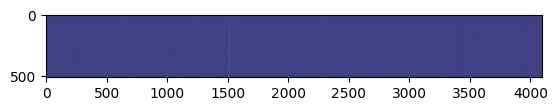

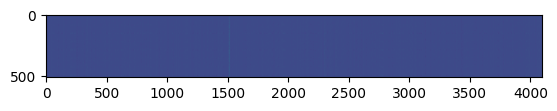

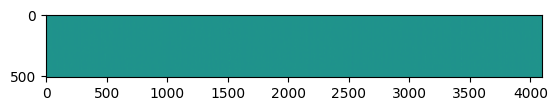

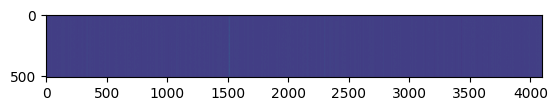

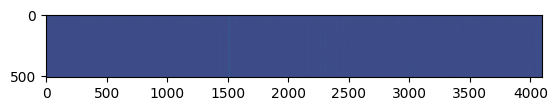

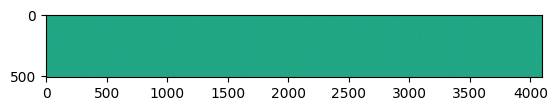

In [20]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from matplotlib.colors import Normalize

print(y.shape)

def imgs(j):
    plt.imshow(y[j].detach().numpy(), cmap='viridis')
    plt.show()

    # increase contrast of x_test
    plt.imshow(y_test[j].detach().numpy(), cmap='viridis')
    plt.show()

    plt.imshow((y[j] - y_test[0]).detach().numpy(), cmap='viridis')
    plt.show()

for j in range(33, 35):
    imgs(j)


In [21]:
# save params of layer
torch.save(layer.state_dict(), 'hyenaa.pt')